In [25]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
dimension = 2
points = 5

In [4]:
def creerPoints(centre, rayon, nb_points=points, nb_dimensions=dimension):
    """
    Fonction de création de points aléatoirement dans un cercle avec un rayon et centre donnés
    """
    result = np.zeros((nb_points, nb_dimensions))
    for j in range(nb_dimensions):
        result[:, j] += centre[j]
    for i in range(nb_points):
        r = rayon*np.random.uniform(0, 1)
        theta = np.random.uniform(0, 2*np.pi)
        result[i, 0] += r*np.cos(theta)
        result[i, 1] += r*np.sin(theta)
    return result

def creerClusters(c1, r1, c2, r2, nb_dimensions=dimension, nb_points=points, createur=creerPoints):
    """
    Crée deux clusters de points grace à la fonction de création passée en paramètre. Ils serviront de source et destination pour l'algorithme de transport
    """
    return createur(c1, r1, nb_points, nb_dimensions), createur(c2, r2, nb_points, nb_dimensions)

def euc_lin(p1, p2, nb_dimensions=dimension, hyperparametre=1):
    """
    Une fonction de cout possible utilisant la distance euclidienne
    """
    x = p2-p1
    return hyperparametre*np.sqrt(np.dot(x, x))

def euc_quadra(p1, p2, nb_dimensions=dimension, hyperparametre=1):
    """
    Une fonction de cout possible utilisant la distance euclidienne au carré
    """
    x = p2-p1
    return hyperparametre*np.dot(x, x)

def cout(p1, p2, nb_dimensions=dimension, fct_cout=euc_quadra, hyperparametre=1):
    """
    Fonction de cout utilisant la fonction passée en paramètre. Par défaut, utilise la distance euclidienne au carré
    """
    return fct_cout(p1, p2, nb_dimensions, hyperparametre)

def creerMatriceCout(source, destination, fct_cout=euc_quadra, hyperparametre=1):
    """
    Création de la matrice de cout C à partir des vecteurs source et destination
    """
    n, p = source.shape
    C = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            C[i, j] = cout(source[i, :], destination[j, :], fct_cout=fct_cout, hyperparametre=hyperparametre)
    return C

def est_sature(i, j, c, phi, psi):
    """
    Test de saturation d'un lien de la matrice de cout C
    """
    return phi[i]+psi[j] == c[i, j]

In [58]:
def afficherClusters(source, destination):
    """
    Fonction d'affichage des deux clusters
    """
    plt.plot(source[:, 0], source[:, 1], 'or')
    plt.plot(destination[:, 0], destination[:, 1], 'ob')
    plt.show()

def displayGraph(P, epsilon):
    G = nx.Graph()

    n, m = P.shape

    sources = [str(i) for i in range(n)]
    destinations = [str(j)+'\'' for j in range(m)]

    # Ajout des arêtes avec des poids
    edges = [(str(i), str(j)+'\'', P[i, j]) for i in range(n) for j in range(m) if P[i, j] > epsilon]

    # Ajout des arêtes au graphe
    for u, v, w in edges:
        G.add_edge(u, v, weight=w)

    # Positions des nœuds pour un affichage clair
    pos = {node: (-1, i) for i, node in enumerate(sources)}  # Sources à gauche
    pos.update({node: (1, i) for i, node in enumerate(destinations)})  # Destinations à droite

    # Dessiner les nœuds et les arêtes
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=12)

    # Récupérer les poids des arêtes
    edge_labels = {(u, v): w for u, v, w in edges}

    # Ajouter les poids sur le graphe
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

    # Affichage
    plt.show()


In [59]:
def trouverChemin(adj, pos, switch, chemin, visite):
    n, _ = adj.shape

    for counter in range(n):
        if switch == 0 :
            if adj[pos][counter] == 1 and visite[pos][counter] == 0:
                chemin.append(counter)
                visite[pos][counter] = 1
                trouverChemin(adj, counter, not(switch), chemin, visite)
                break
        else :
            if adj[counter][pos] == 1 and visite[counter][pos] == 0:
                chemin.append(counter)
                visite[counter][pos] = 1
                trouverChemin(adj, counter, not(switch), chemin, visite)
                break

def inverser(x, chemin):
    for i in range(len(chemin)-1):
        if (i % 2 == 0):
            x[chemin[i], chemin[i+1]] = int(not(x[chemin[i], chemin[i+1]]))
        else:
            x[chemin[i+1], chemin[i]] = int(not(x[chemin[i+1], chemin[i]]))

def hongrois(source, destination):
    n, p = source.shape
    c = creerMatriceCout(source, destination) # np.array([[1, 4, 2], [3, 5, 6], [2, 1, 3]]) 
    x = np.zeros_like(c)
    adj = np.zeros_like(c) # matrice d'adjacence bipartite
    visite = np.zeros_like(c)
    phi = np.zeros(n)
    psi = np.zeros(n)

    # initialisation

    for i in range(n):
        phi[i] = np.min(c[i, :])
    
    for j in range(n):
        psi[j] = np.min(c[:, j]-phi)

    for i in range(n):
        for j in range(n):
            if est_sature(i, j, c, phi, psi):
                adj[i, j] = 1

    for i in range(n):
        for j in range(n):
            if (adj[i, j] == 1 and not(1 in x[:, j])):
                x[i, j] = 1
                break

    # boucle principale

    depart = None

    for i in range(n):
        if not(1 in x[i, :]):
            chemin = [i]
            trouverChemin(adj, 1, 0, chemin, visite) #pb, il faut que le chemin finisse à droite et soit pas trop petit
            inverser(x, chemin)

    # il faut rajouter la procedure quand on a pas de chemin augmentant (page 49)

    cout_transport = np.sum(phi)+np.sum(psi)

    return x, adj, cout_transport



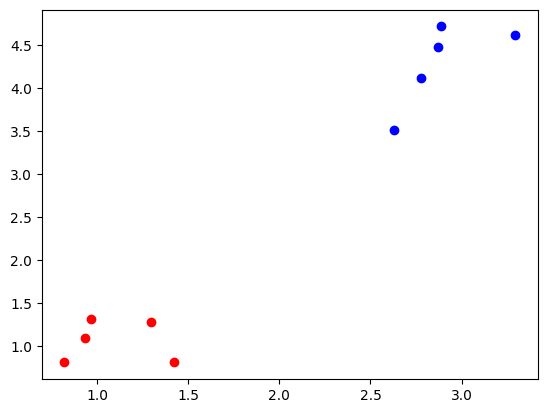

[[13.66188162 16.30660743 11.11944129  7.60788078 15.25546806]
 [15.21541993 17.94471114 12.50631041  8.72387356 16.912502  ]
 [17.68264507 20.58500493 14.74280027 10.58570954 19.51630854]
 [15.56929462 17.96148259 12.74257796  8.76655848 17.38685922]
 [12.73312213 15.10747491 10.22695834  6.77280395 14.3343163 ]]


In [60]:
c1, r1 = [1, 1], 0.5
c2, r2 = [3, 4], 0.8

A, B = creerClusters(c1, r1, c2, r2)
C = creerMatriceCout(A, B, fct_cout=euc_quadra)

afficherClusters(A, B)
print(C)

In [61]:
x, adj, cout_transport = hongrois(A, B)
print("Assignations : ")
print(x)
print("Cout total du transport : ", cout_transport)

Assignations : 
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
Cout total du transport :  67.76748218098578


In [62]:
def NW(a, b):
    n = a.size
    m = b.size
    i = 0
    j = 0
    r = a[0]
    c = b[0]
    P = np.zeros((n, m))
    while i < n and j < m :
        t = min(r, c)
        P[i, j] = t
        r = r-t
        c= c-t
        if r == 0:
            i += 1
            if  i < n:
                r = a[i]
        if c == 0:
            j += 1
            if j < m:
                c = b[j]
    return P


[[0.1  0.06 0.   0.   0.   0.  ]
 [0.   0.1  0.3  0.   0.   0.  ]
 [0.   0.   0.   0.06 0.   0.  ]
 [0.   0.   0.   0.04 0.2  0.  ]
 [0.   0.   0.   0.   0.   0.14]]


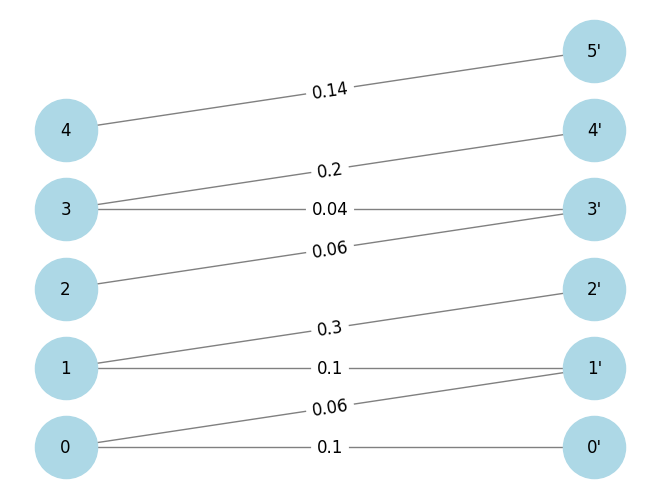

In [65]:
a = np.array([0.16, 0.4, 0.06, 0.24, 0.14])
b = np.array([0.1, 0.16, 0.3, 0.1, 0.2, 0.14])
P = NW(a, b).round(3)
print(P)
displayGraph(P, 1e-5)